In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  0


In [4]:
metadata = pd.read_csv('/content/drive/MyDrive/archive (17)/bird_songs_metadata.csv')
metadata.head()

id       genus   species subspecies           name  \
0  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
1  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
2  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
3  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
4  557838  Thryomanes  bewickii        NaN  Bewick's Wren   

                recordist        country  \
0  Whitney Neufeld-Kaiser  United States   
1  Whitney Neufeld-Kaiser  United States   
2  Whitney Neufeld-Kaiser  United States   
3  Whitney Neufeld-Kaiser  United States   
4  Whitney Neufeld-Kaiser  United States   

                                  location  latitude  longitude altitude  \
0  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
1  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
2  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
3  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
4  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   

                   sound_type                   source_url  \
0  adult, sex uncertain, song  //www.xeno-canto.org/557838   
1  adult, sex uncertain, song  //www.xeno-canto.org/557838   
2  adult, sex uncertain, song  //www.xeno-canto.org/557838   
3  adult, sex uncertain, song  //www.xeno-canto.org/557838   
4  adult, sex uncertain, song  //www.xeno-canto.org/557838   

                                        license   time        date  \
0  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
1  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
2  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
3  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
4  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   

                                             remarks      filename  
0  Recorded with Voice Record Pro on iPhone7, nor...  557838-0.wav  
1  Recorded with Voice Record Pro on iPhone7, nor...  557838-1.wav  
2  Recorded with Voice Record Pro on iPhone7, nor...  557838-4.wav  
3  Recorded with Voice Record Pro on iPhone7, nor...  557838-5.wav  
4  Recorded with Voice Record Pro on iPhone7, nor...  557838-6.wav

In [5]:
# Lists for storing the filepaths and labels
file_paths = []
labels = []

audio_dir = '/content/drive/MyDrive/archive (17)/wavfiles/'

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    if os.path.exists(file_path):
        file_paths.append(file_path)
        labels.append(row['species'])

file_paths[:5], labels[:5]

(['/content/drive/MyDrive/archive (17)/wavfiles/557838-0.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-1.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-4.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-5.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-6.wav'],
 ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii'])

In [6]:
bird_labels = metadata['species']
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

In [7]:
# Function to read audio file
def read_file(path):
    y, _ = librosa.load(path, sr=22050)  # Set the sample rate to ensure consistency
    return y

# Function to convert to dB scale
def spec_to_db(y):
    y_db = librosa.power_to_db(y, ref=np.max)
    #y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    # Load audio file
    y = tf.numpy_function(read_file, inp=[path_tensor], Tout=tf.float32)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))

    mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=tf.shape(spectrogram)[-1],
        sample_rate=22050,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0)
    mel_spectrogram = tf.matmul(spectrogram, mel_weights)

    # Convert to dB scale
    #log_mel_spectrogram = tf.numpy_function(spec_to_db, inp=[mel_spectrogram], Tout=tf.float32)

    #spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    #spectrogram_db = spectrogram_db/80+1

    return mel_spectrogram, label


def make_dataset(bird_labels, file_paths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    file_paths = tf.convert_to_tensor(file_paths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    file_paths = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = tf.data.Dataset.zip( file_paths, bird_labels)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 64, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

In [56]:
file_paths_train, file_paths_test, y_train, y_test = train_test_split(
    file_paths, bird_labels, test_size=0.20, random_state=42)

print(len(file_paths_test))
print(len(y_test))



dataset_train = make_dataset(y_train, file_paths_train, shuffle=True)
dataset_test = make_dataset(y_test, file_paths_test, shuffle=False)

for batch in dataset_train.take(1):
    input_data_shape = batch[0].shape
print("Shape of input data in training dataset:", input_data_shape)

1085
1085
Shape of input data in training dataset: (64, 1026, 128)


In [10]:
import zipfile

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


zip_file_path = '/model_CNN_mel.zip'
extract_to = '/content/model_CNN_mel'

unzip_file(zip_file_path, extract_to)

In [11]:
model_CNN = tf.keras.models.load_model('/content/model_CNN_mel/model_CNN_mel')
model_CNN.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 128)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 64)           65600     
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 64)           0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 64)           32832     
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 64)           0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

In [12]:
model_CNN.evaluate(dataset_test, return_dict=True)

16/16 [==============================] - 142s 9s/step - loss: 0.1741 - sparse_categorical_accuracy: 0.9551


{'loss': 0.17405126988887787, 'sparse_categorical_accuracy': 0.955078125}

In [13]:
y_logits_CNN = model_CNN.predict(dataset_test)
y_prob_CNN = tf.nn.softmax(y_logits_CNN, axis=1)
y_pred_CNN = tf.argmax(y_logits_CNN, axis=1)
y_true_CNN = tf.concat(list(dataset_test.map(lambda s,lab: lab)), axis=0)

16/16 [==============================] - 4s 234ms/step


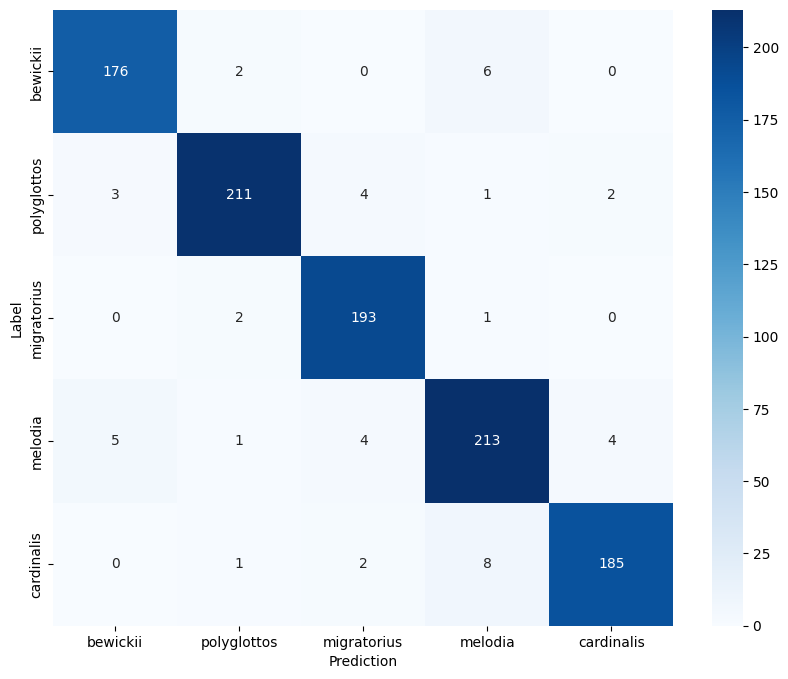

In [26]:
confusion_mtx_CNN = tf.math.confusion_matrix(y_true_CNN, y_pred_CNN)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_CNN,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [39]:
model_CNN_RNN = tf.keras.models.load_model('/content/model_CNN_RNN')
model_CNN_RNN.summary()

Model: "Bird_audio_classification_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 0_Input_shape (InputLayer)  [(None, 1026, 128)]          0         []                            
                                                                                                  
 1_Conv1D (Conv1D)           (None, 513, 64)              65600     ['0_Input_shape[0][0]']       
                                                                                                  
 2_SpatialDropout1D (Spatia  (None, 513, 64)              0         ['1_Conv1D[0][0]']            
 lDropout1D)                                                                                      
                                                                                                  
 3_Conv1d (Conv1D)           (None, 257, 64)              32832     

In [40]:
model_CNN_RNN.evaluate(dataset_test, return_dict=True)

16/16 [==============================] - 5s 249ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9668


{'loss': 0.17179538309574127, 'sparse_categorical_accuracy': 0.966796875}

In [41]:
y_logits_CNN_RNN = model_CNN_RNN.predict(dataset_test)
y_prob_CNN_RNN = tf.nn.softmax(y_logits_CNN_RNN, axis=1)
y_pred_CNN_RNN = tf.argmax(y_logits_CNN_RNN, axis=1)
y_true_CNN_RNN = tf.concat(list(dataset_test.map(lambda s,lab: lab)), axis=0)

16/16 [==============================] - 5s 251ms/step


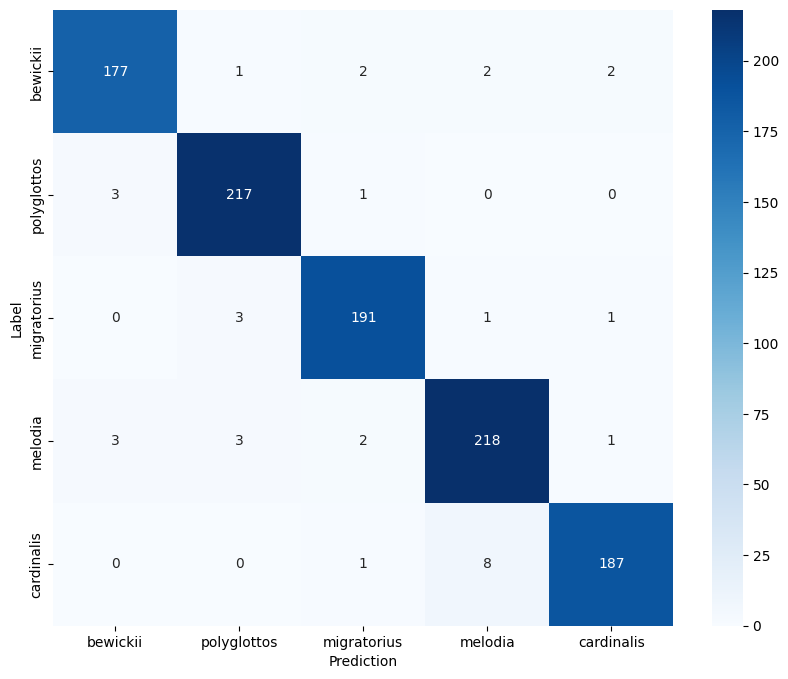

In [42]:
confusion_mtx_CNN_RNN = tf.math.confusion_matrix(y_true_CNN_RNN, y_pred_CNN_RNN)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_CNN_RNN,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [46]:
y_true_CNN_numpy = y_true_CNN.numpy()
y_pred_CNN_numpy = y_pred_CNN.numpy()

y_true_CNN_RNN_numpy = y_true_CNN_RNN.numpy()
y_pred_CNN_RNN_numpy = y_pred_CNN_RNN.numpy()

dataset_test_tensors = []
for ds in dataset_test:
    mel = ds[0]
    dataset_test_tensors.append(mel)

dataset_test_mels = [item for sublist in dataset_test_tensors for item in sublist]

In [75]:
indices = np.where((y_pred_CNN_numpy == 3) & (y_true_CNN_numpy == 0))[0]
print("Indices where y_pred is 3 and y_true is 0:", indices)

indices_1 = np.where((y_pred_CNN_numpy == 3) & (y_true_CNN_numpy == 4))[0]
print("Indices where y_pred is 3 and y_true is 0:", indices_1)

indices_2 = np.where((y_pred_CNN_RNN_numpy == 3) & (y_true_CNN_RNN_numpy == 4))[0]
print("Indices where y_pred is 3 and y_true is 0:", indices_2)

Indices where y_pred is 3 and y_true is 0: [ 69 124 346 705 810 893]
Indices where y_pred is 3 and y_true is 0: [205 455 562 572 586 622 807 940]
Indices where y_pred is 3 and y_true is 0: [205 455 572 586 622 807 820 940]


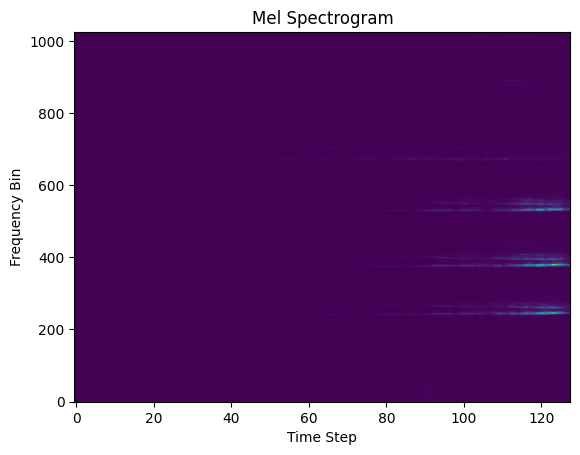

---------CNN------------


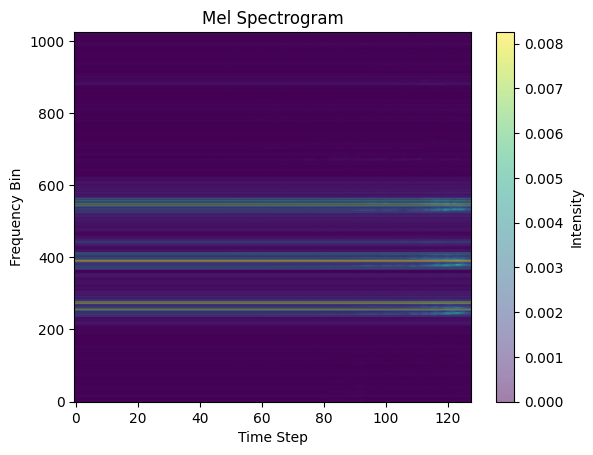

---------CNN+RNN--------


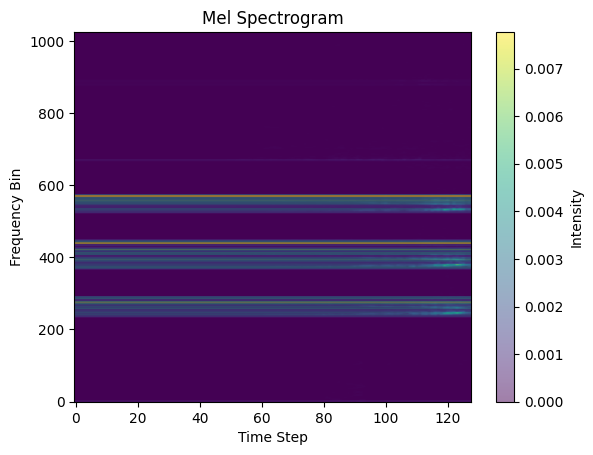

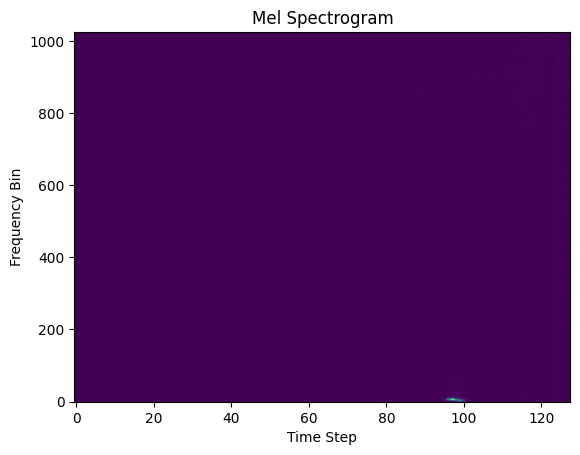

---------CNN------------


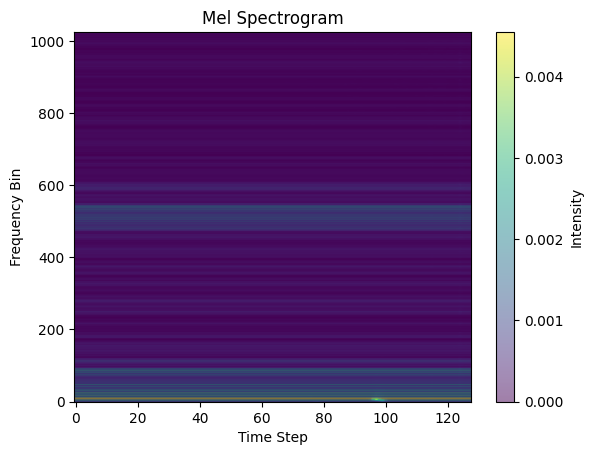

---------CNN+RNN--------


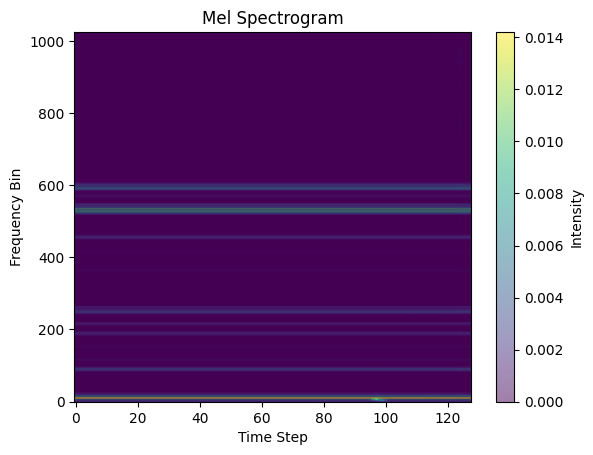

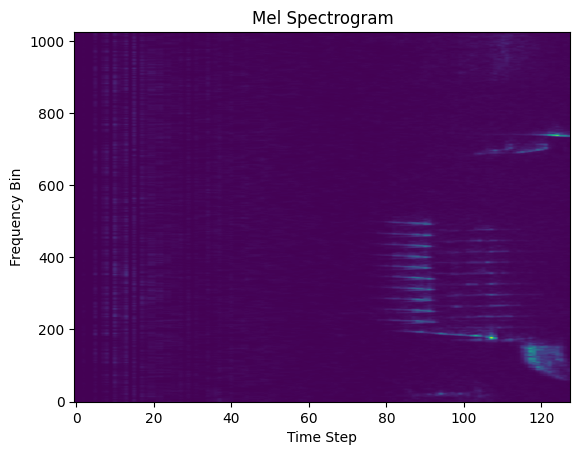

---------CNN------------


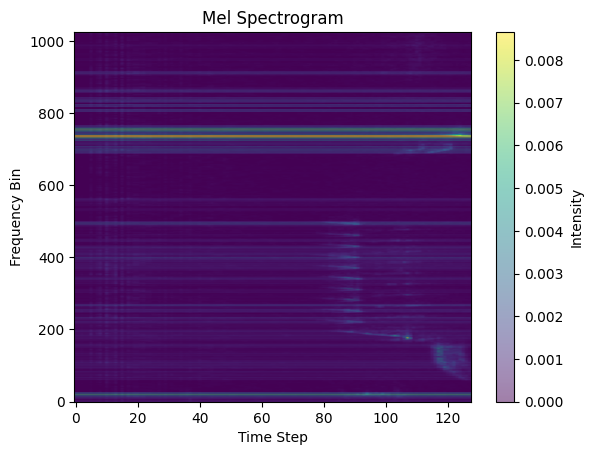

---------CNN+RNN--------


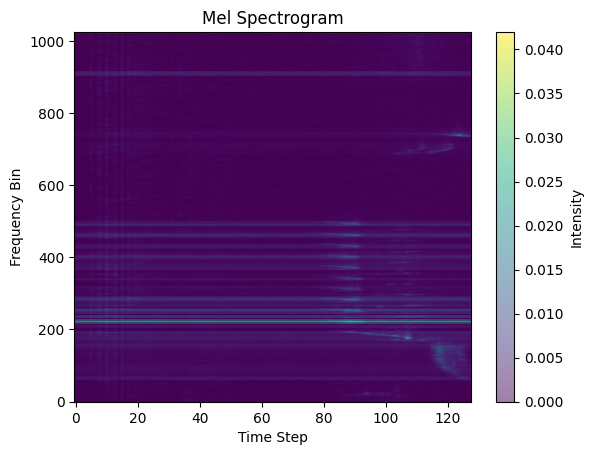

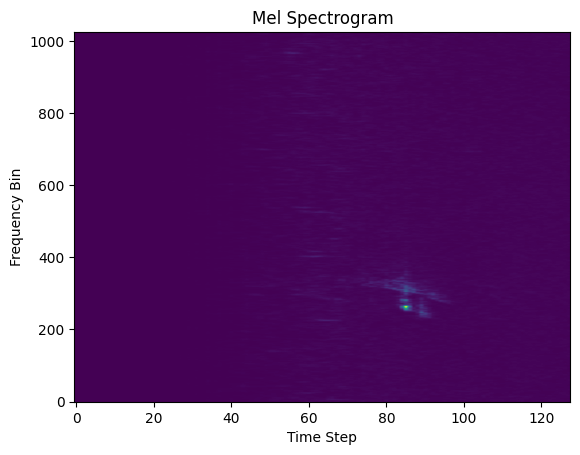

---------CNN------------


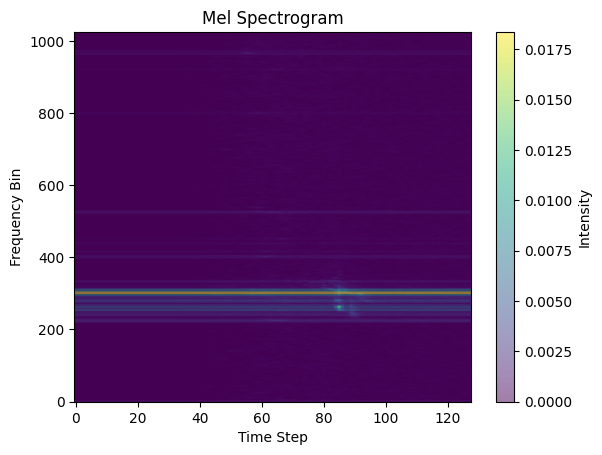

---------CNN+RNN--------


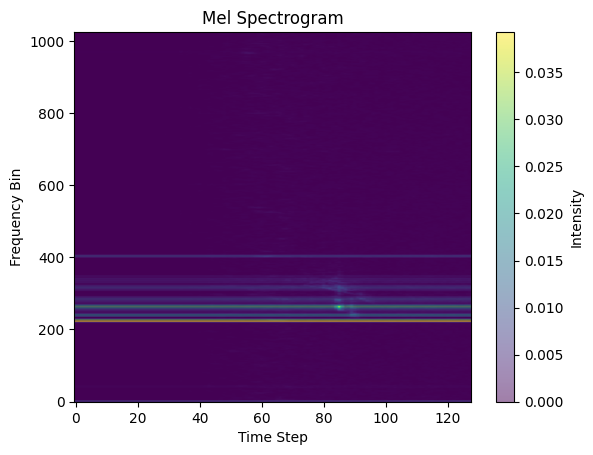

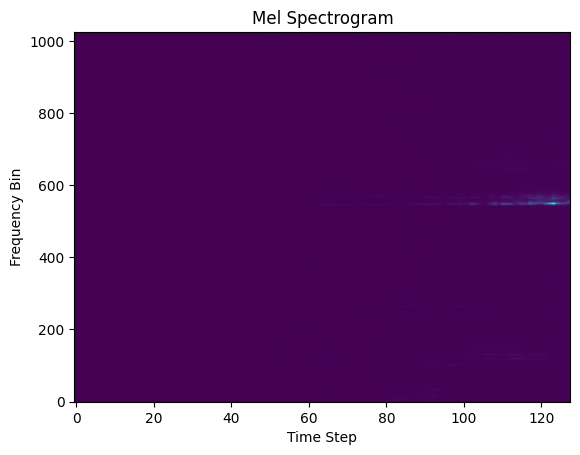

---------CNN------------


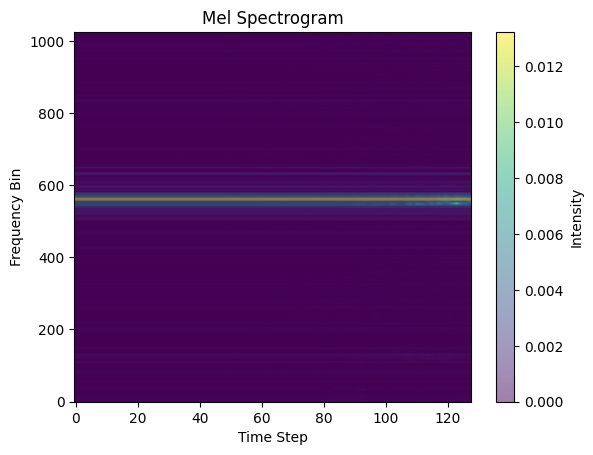

---------CNN+RNN--------


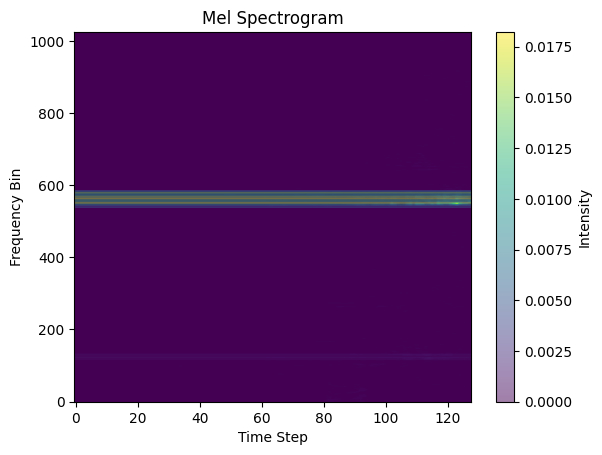

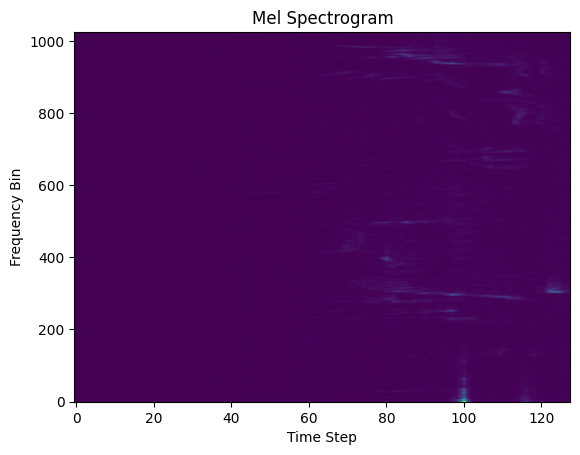

---------CNN------------


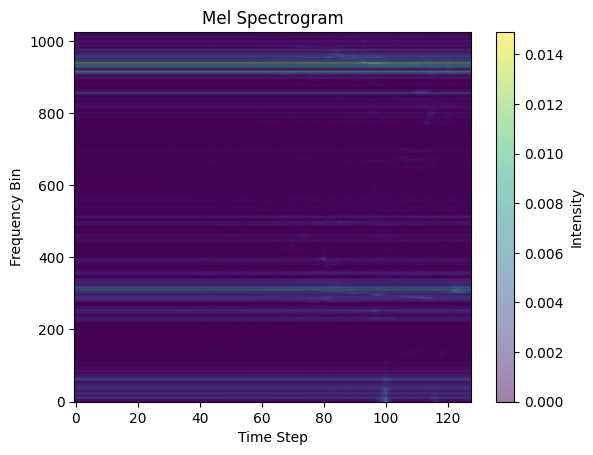

---------CNN+RNN--------


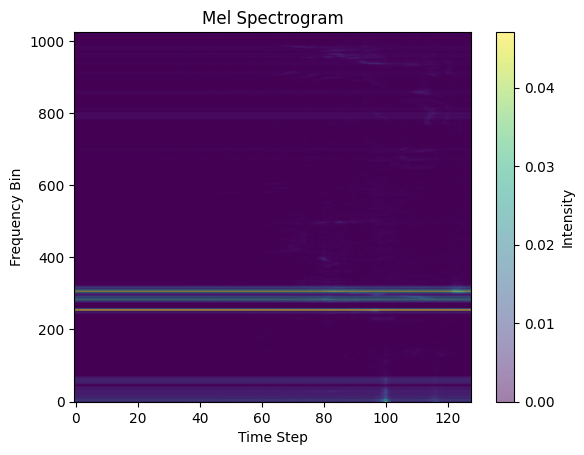

In [43]:
def compute_saliency_map(model, input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image, training=False)
        top_prediction = tf.argmax(predictions[0])
        top_class_output = predictions[:, top_prediction]

    gradients = tape.gradient(top_class_output, input_image)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency_map[0]


for i in indices:
    mel_spectrogram = dataset_test_mels[i]
    mel_spectrogram_expanded = mel_spectrogram[np.newaxis, ...]
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    plt.show()

    print("---------CNN------------")
    saliency_map = compute_saliency_map(model_CNN, mel_spectrogram_expanded)
    saliency_map_reshaped = tf.repeat(tf.expand_dims(saliency_map, axis=1), repeats=128, axis=1)
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.imshow(saliency_map_reshaped, aspect='auto', cmap='viridis', alpha=0.5, interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    cbar = plt.colorbar()
    cbar.set_label('Intensity')
    plt.show()

    print("---------CNN+RNN--------")
    saliency_map = compute_saliency_map(model_CNN_RNN, mel_spectrogram_expanded)
    saliency_map_reshaped = tf.repeat(tf.expand_dims(saliency_map, axis=1), repeats=128, axis=1)
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.imshow(saliency_map_reshaped, aspect='auto', cmap='viridis', alpha=0.5, interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    cbar = plt.colorbar()
    cbar.set_label('Intensity')
    plt.show()





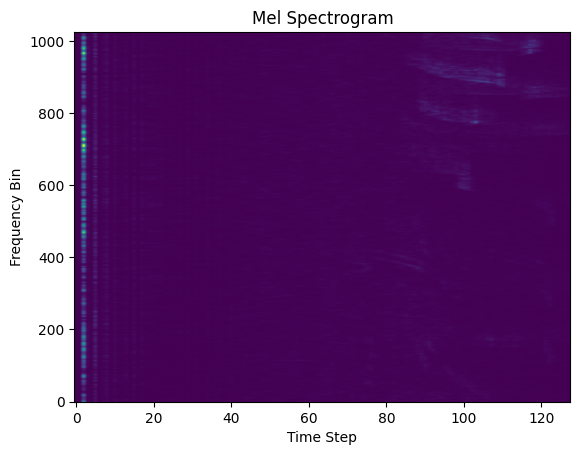

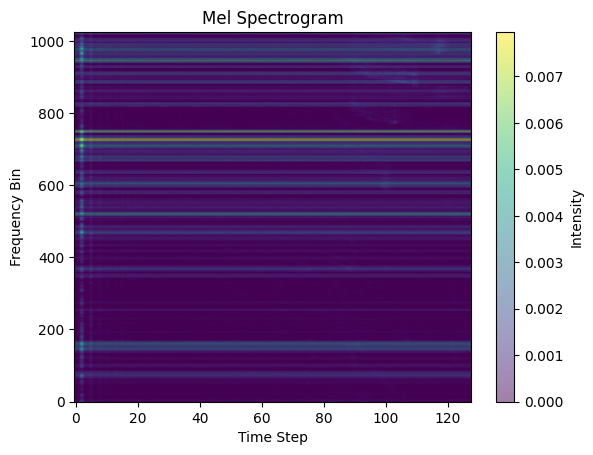

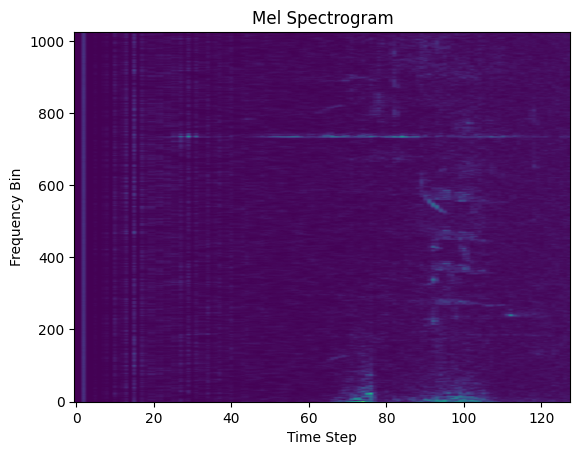

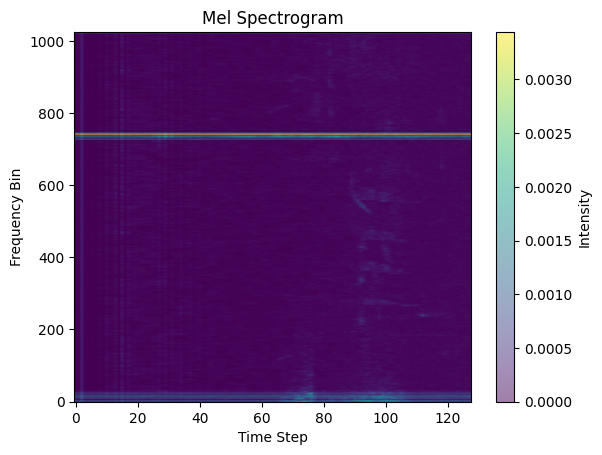

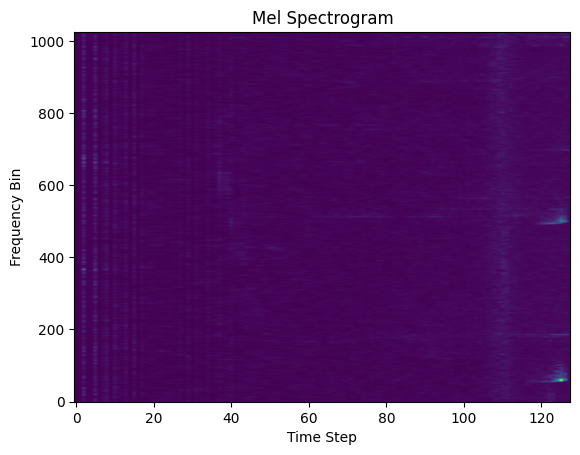

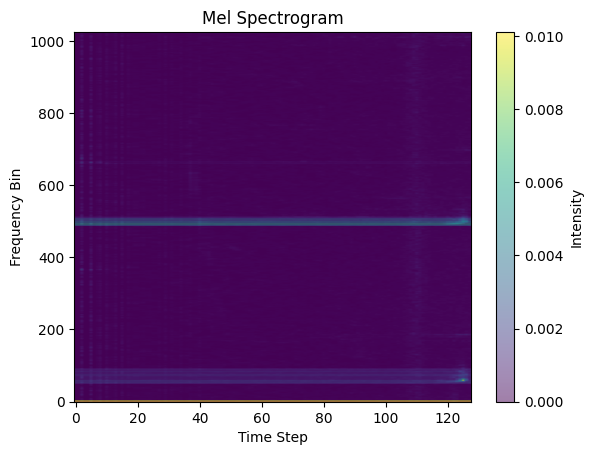

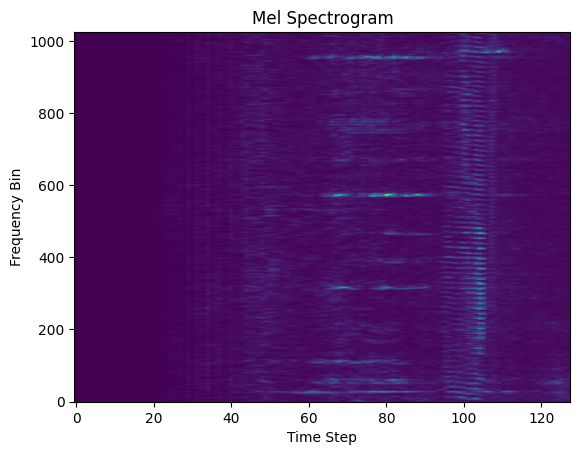

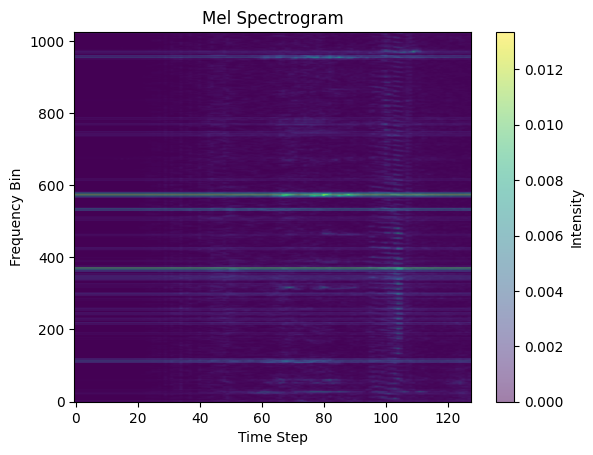

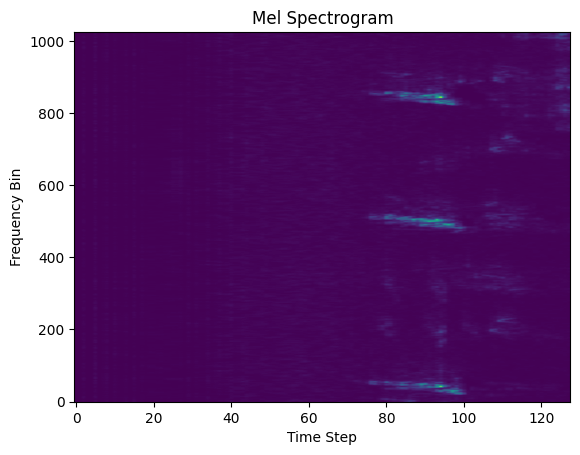

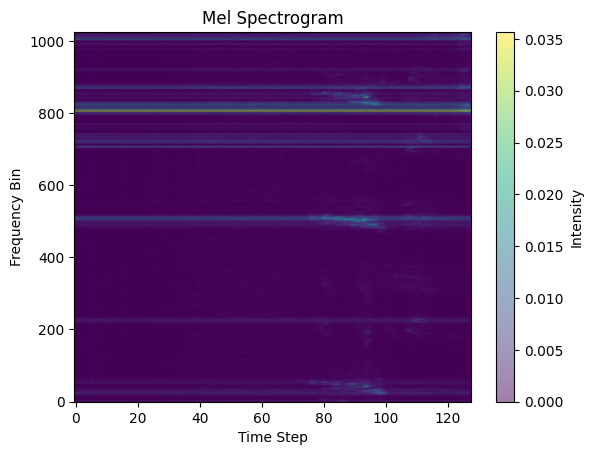

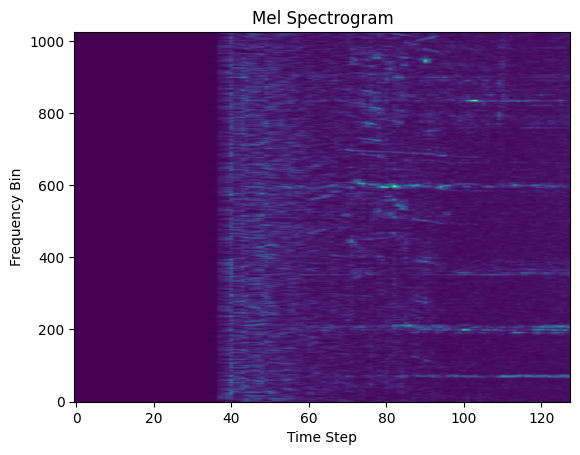

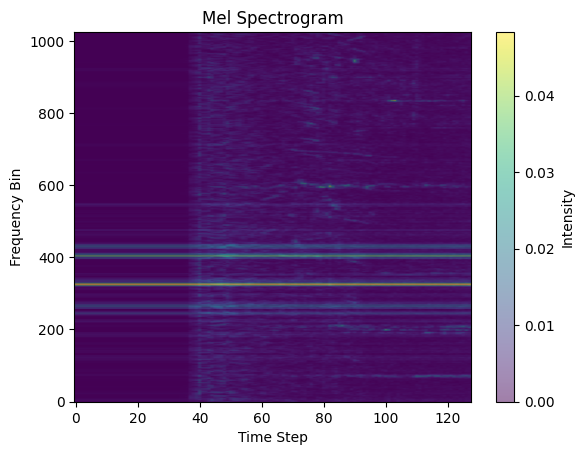

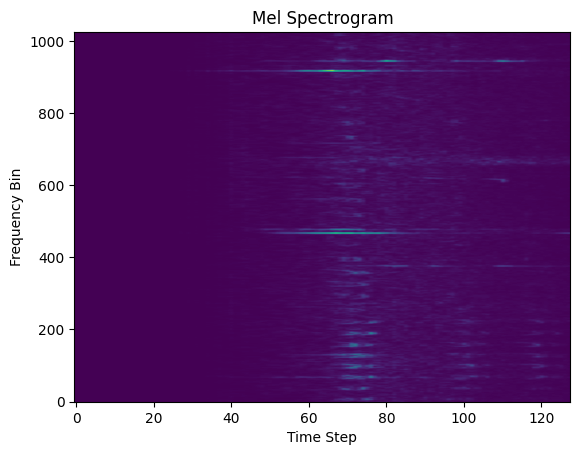

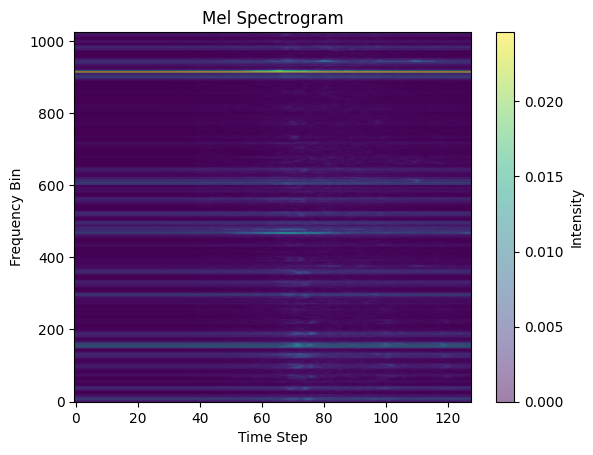

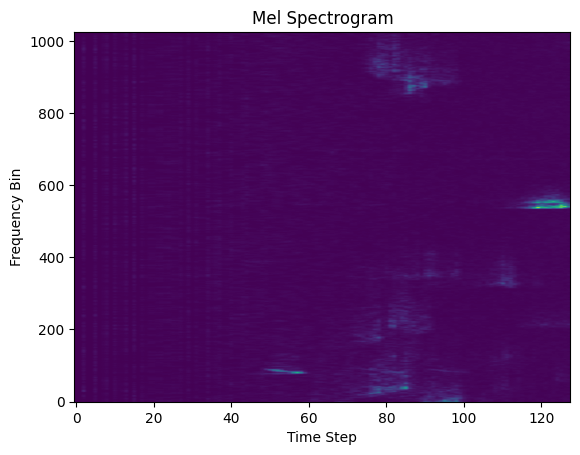

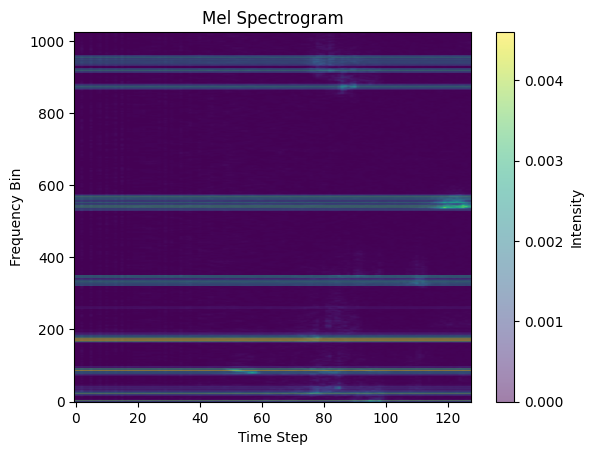

In [81]:
for i in indices_2:
    mel_spectrogram = dataset_test_mels[i]
    mel_spectrogram_expanded = mel_spectrogram[np.newaxis, ...]
    plt.imshow(mel_spectrogram, aspect='auto')
    plt.gca().invert_yaxis()
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    plt.show()

    saliency_map = compute_saliency_map(model_CNN_RNN, mel_spectrogram_expanded)
    saliency_map_reshaped = tf.repeat(tf.expand_dims(saliency_map, axis=1), repeats=128, axis=1)
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.imshow(saliency_map_reshaped, aspect='auto', cmap='viridis', alpha=0.5, interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.xlabel('Time Step')
    plt.ylabel('Frequency Bin')
    plt.title('Mel Spectrogram')
    cbar = plt.colorbar()
    cbar.set_label('Intensity')
    plt.show()


In [73]:
from IPython.display import Audio

for i in indices_2:
    display(Audio(file_paths_test[i]))


In [76]:
for i in indices:
    display(Audio(file_paths_test[i]))